# Voice Activity Detection

<div class="alert alert-info">

This tutorial is available as an IPython notebook at [malaya-speech/example/vad](https://github.com/huseinzol05/malaya-speech/tree/master/example/vad).
    
</div>

<div class="alert alert-info">

This module is language independent, so it save to use on different languages. Pretrained models trained on multilanguages.
    
</div>

<div class="alert alert-warning">

This is an application of malaya-speech Pipeline, read more about malaya-speech Pipeline at [malaya-speech/example/pipeline](https://github.com/huseinzol05/malaya-speech/tree/master/example/pipeline).
    
</div>

### Dataset

Trained on MUSAN and selected Youtube videos gathered at https://github.com/huseinzol05/malaya-speech/tree/master/data/noise

In [1]:
import malaya_speech
import numpy as np
from malaya_speech import Pipeline

In [3]:
y, sr = malaya_speech.load('speech/7021-79759-0004.wav')
len(y), sr

(391520, 16000)

### Load WebRTC

```python
def webrtc(
    aggressiveness: int = 3,
    sample_rate: int = 16000,
    minimum_amplitude: int = 100,
):
    """
    Load WebRTC VAD model.

    Parameters
    ----------
    aggressiveness: int, optional (default=3)
        an integer between 0 and 3.
        0 is the least aggressive about filtering out non-speech, 3 is the most aggressive.
    sample_rate: int, optional (default=16000)
        sample rate for samples.
    minimum_amplitude: int, optional (default=100)
        abs(minimum_amplitude) to assume a sample is a voice activity. Else, automatically False.

    Returns
    -------
    result : malaya_speech.model.webrtc.WEBRTC class
    """
```

WebRTC developed by Google, reportedly one of the best available, being fast, modern and free. Read more about pywebrtc at https://github.com/wiseman/py-webrtcvad.

**For WebRTC, we need to pass integer signal**.

Install `webrtcvad` by simply using PIP,

```bash
pip3 install webrtcvad
```

In [4]:
y_int = malaya_speech.astype.float_to_int(y)
vad = malaya_speech.vad.webrtc(minimum_amplitude = int(np.quantile(np.abs(y_int), 0.2)))

### List available deep model

In [5]:
malaya_speech.vad.available_model()

,Size (MB),Quantized Size (MB),Accuracy
vggvox-v1,70.800,17.700,0.809844
vggvox-v2,31.100,7.920,0.819688
speakernet,20.300,5.180,0.734062
marblenet-factor1,0.526,0.232,0.849187
marblenet-factor3,3.210,0.934,0.838556
marblenet-factor5,8.380,2.210,0.843541


### Load deep model

Deep model trained on different noises, augmented noises, procedural noises, overlapped noises and actual voices.

```python
def deep_model(model: str = 'marblenet-factor1', quantized: bool = False, **kwargs):
    """
    Load VAD model.

    Parameters
    ----------
    model : str, optional (default='vggvox-v2')
        Model architecture supported. Allowed values:

        * ``'vggvox-v1'`` - finetuned VGGVox V1.
        * ``'vggvox-v2'`` - finetuned VGGVox V2.
        * ``'speakernet'`` - finetuned SpeakerNet.
        * ``'marblenet-factor1'`` - Pretrained MarbleNet * factor 1.
        * ``'marblenet-factor3'`` - Pretrained MarbleNet * factor 3.
        * ``'marblenet-factor5'`` - Pretrained MarbleNet * factor 5.

    quantized : bool, optional (default=False)
        if True, will load 8-bit quantized model.
        Quantized model not necessary faster, totally depends on the machine.

    Returns
    -------
    result : malaya_speech.supervised.classification.load function
    """
```

In [64]:
model_factor1 = malaya_speech.vad.deep_model(model = 'marblenet-factor1')
model_factor3 = malaya_speech.vad.deep_model(model = 'marblenet-factor3')

### How to detect Voice Activity

In order to use available Malaya-Speech VAD models, we need to split our audio sample into really small chunks. 

For Google WebRTC, we need to split by every 10, 20 or 30 ms. 

For deep learning,

- `vggvox-v1`, `vggvox-v2` and `speakernet`, we trained on 30 ms, 90 ms.
- `marblenet`, we trained on 50 ms.

To split an audio sample by giving time split, use, [malaya_speech.utils.generator.frames](https://github.com/huseinzol05/malaya-speech/blob/master/malaya_speech/utils/generator.py#L7)

```python
def frames(
    audio,
    frame_duration_ms: int = 30,
    sample_rate: int = 16000,
    append_ending_trail: bool = True,
):
    """
    Generates audio frames from PCM audio data.
    Takes the desired frame duration in milliseconds, the PCM data, and the sample rate.

    Parameters
    ----------

    audio: np.array / list
    frame_duration_ms: int, optional (default=30)
    sample_rate: int, optional (default=16000)
    append_ending_trail: bool, optional (default=True)
        if True, will append last trail and this last trail might not same length as `frame_duration_ms`.

    Returns
    -------
    result: List[malaya_speech.model.frame.FRAME]
    """
```

In [8]:
%%time

frames_int = list(malaya_speech.utils.generator.frames(y_int, 30, sr))
frames = list(malaya_speech.utils.generator.frames(y, 30, sr))

CPU times: user 3.1 ms, sys: 145 µs, total: 3.25 ms
Wall time: 3.4 ms


In [9]:
%%time

frames_webrtc = [(frame, vad(frame)) for frame in frames_int]

CPU times: user 22.6 ms, sys: 1.41 ms, total: 24 ms
Wall time: 23.5 ms


In [22]:
%%time

frames = list(malaya_speech.utils.generator.frames(y, 50, sr))
frames_deep_factor1 = [(frame, model_factor1(frame)) for frame in frames]

CPU times: user 752 ms, sys: 53.5 ms, total: 806 ms
Wall time: 598 ms


In [23]:
%%time

frames_deep_factor3 = [(frame, model_factor3(frame)) for frame in frames]

CPU times: user 848 ms, sys: 57.5 ms, total: 906 ms
Wall time: 667 ms


**To speedup, you can do pipeline batching to utilize parallel processing or use GPU or both**.

#### Batching pipeline

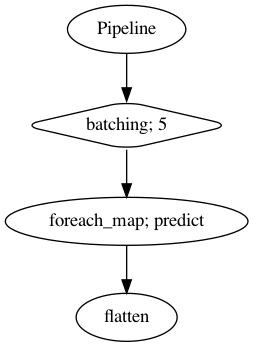

In [24]:
p = Pipeline()
pipeline = (
    p.batching(5)
    .foreach_map(model_factor1.predict)
    .flatten()
)
p.visualize()

In [25]:
%%time

result = p.emit(frames)
result.keys()

CPU times: user 433 ms, sys: 46.4 ms, total: 479 ms
Wall time: 227 ms


dict_keys(['batching', 'predict', 'flatten'])

In [26]:
frames_deep_factor1_batch = [(frame, result['flatten'][no]) for no, frame in enumerate(frames)]

In [28]:
len(frames_deep_factor1) == len(frames_deep_factor1_batch)

True

#### get probability

Deep learning model able to calculate probability, simply use `model.predict_proba`, and make sure the input is an array or a list,

In [29]:
%%time

probs = [(frame, model_factor1.predict_proba([frame])) for frame in frames]
probs[:5]

CPU times: user 735 ms, sys: 51.1 ms, total: 786 ms
Wall time: 603 ms


[(<malaya_speech.model.frame.Frame at 0x147d841d0>,
  array([[0.4536493, 0.5463507]], dtype=float32)),
 (<malaya_speech.model.frame.Frame at 0x147d84e50>,
  array([[0.99563223, 0.00436788]], dtype=float32)),
 (<malaya_speech.model.frame.Frame at 0x147d84f10>,
  array([[9.9996042e-01, 3.9535582e-05]], dtype=float32)),
 (<malaya_speech.model.frame.Frame at 0x147d84210>,
  array([[0.89770913, 0.10229082]], dtype=float32)),
 (<malaya_speech.model.frame.Frame at 0x147d84d90>,
  array([[0.48591104, 0.514089  ]], dtype=float32))]

### VAD Visualization

We can visualize our audio sample to annotate which parts are active speech or not.

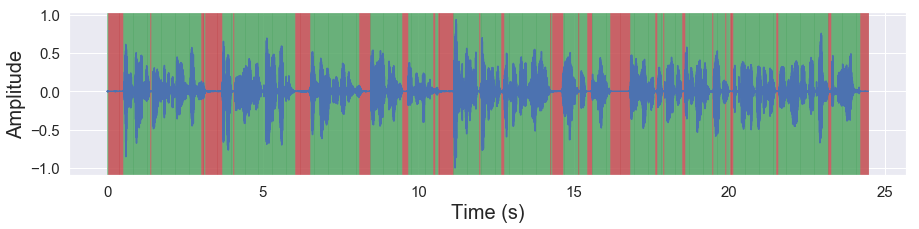

In [31]:
malaya_speech.extra.visualization.visualize_vad(y, frames_webrtc, sr)

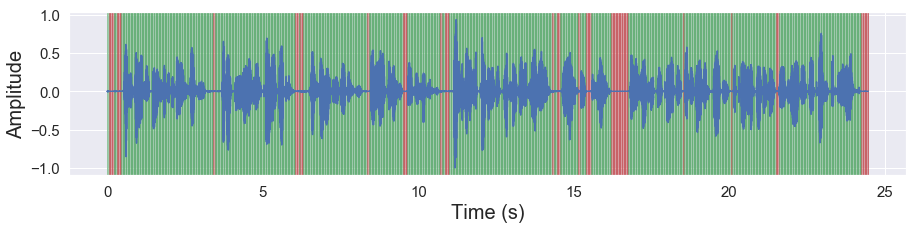

In [33]:
malaya_speech.extra.visualization.visualize_vad(y, frames_deep_factor1, sr)

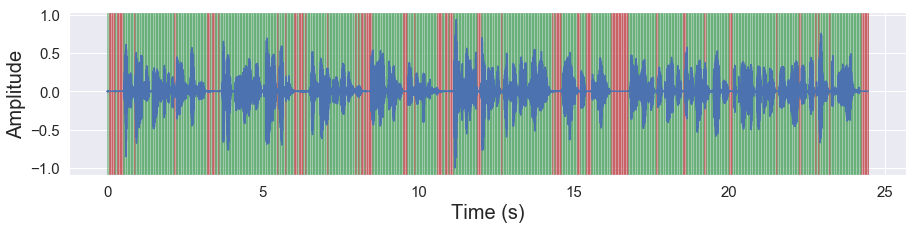

In [34]:
malaya_speech.extra.visualization.visualize_vad(y, frames_deep_factor3, sr)

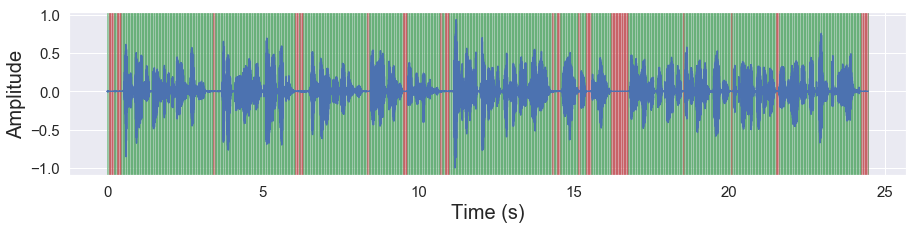

In [35]:
malaya_speech.extra.visualization.visualize_vad(y, frames_deep_factor1_batch, sr)

### Groupby VAD

To group small samples into larger samples, use `malaya_speech.utils.group.group_frames`,

```python
def group_frames(frames):
    """
    Group multiple frames based on label.

    Parameters
    ----------
    frames: List[Tuple[Frame, label]]

    Returns
    -------
    result : List[Tuple[Frame, label]]
    """
```

In [36]:
grouped_vad = malaya_speech.utils.group.group_frames(frames_webrtc)
grouped_deep = malaya_speech.utils.group.group_frames(frames_deep_factor1)

In [37]:
len(frames), len(grouped_vad), len(grouped_deep)

(490, 52, 36)

### Harder example

In the real world, not all samples recorded in clean cut studio, full with background noises, music and etc. So those are not the real voice activities. Lets take noise sound,

In [38]:
y, sr = malaya_speech.load('speech/noise/n98.wav')
len(y), sr

(64000, 16000)

In [39]:
%%time

y_int = malaya_speech.astype.float_to_int(y)
frames_int = list(malaya_speech.utils.generator.frames(y_int, 30, sr))

CPU times: user 1.63 ms, sys: 961 µs, total: 2.59 ms
Wall time: 1.55 ms


In [40]:
%%time

vad = malaya_speech.vad.webrtc(minimum_amplitude = int(np.quantile(np.abs(y_int), 0.2)))
frames_webrtc = [(frame, vad(frame)) for frame in frames_int]

CPU times: user 6.78 ms, sys: 1.87 ms, total: 8.66 ms
Wall time: 6.86 ms


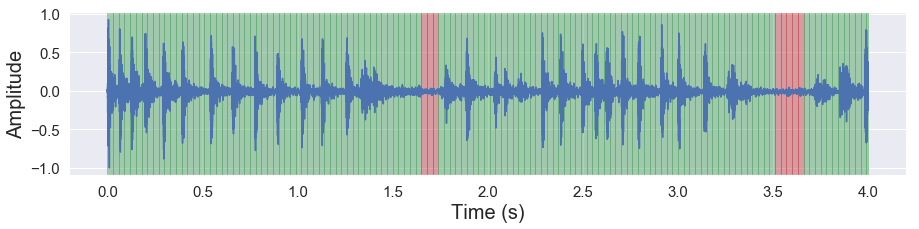

In [41]:
malaya_speech.extra.visualization.visualize_vad(y, frames_webrtc, sr)

In [42]:
%%time

frames = list(malaya_speech.utils.generator.frames(y, 50, sr))
result = p.emit(frames)
frames_deep_batch = [(frame, result['flatten'][no]) for no, frame in enumerate(frames)]

CPU times: user 96.2 ms, sys: 10 ms, total: 106 ms
Wall time: 52.9 ms


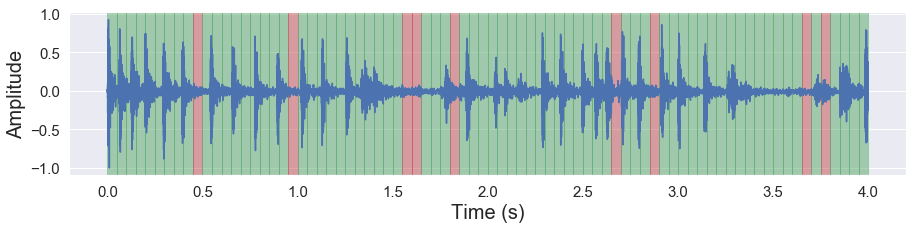

In [43]:
malaya_speech.extra.visualization.visualize_vad(y, frames_deep_batch, sr)

In [44]:
%%time

frames_deep_factor3 = [(frame, model_factor3(frame)) for frame in frames]

CPU times: user 206 ms, sys: 16.7 ms, total: 223 ms
Wall time: 168 ms


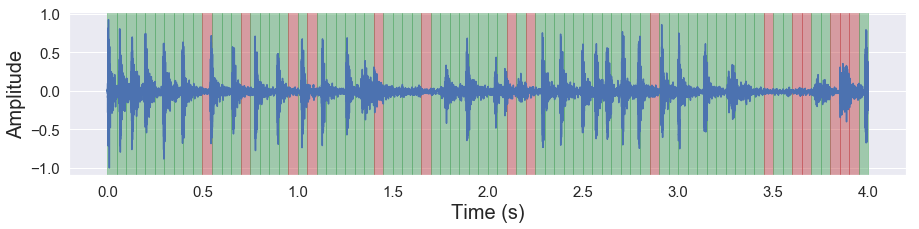

In [45]:
malaya_speech.extra.visualization.visualize_vad(y, frames_deep_factor3, sr)

As you can see, the deep model able to know this sample mostly noises!

In [46]:
y, sr = malaya_speech.load('speech/podcast/2x5%20Ep%2010.wav')
y = y[: sr * 10]
len(y), sr

(160000, 16000)

In [47]:
y_int = malaya_speech.utils.astype.float_to_int(y)

frames = list(malaya_speech.utils.generator.frames(y, 30, sr))
frames_int = list(malaya_speech.utils.generator.frames(y_int, 30, sr))

In [48]:
%%time

vad = malaya_speech.vad.webrtc(minimum_amplitude = int(np.quantile(np.abs(y_int), 0.2)))
frames_webrtc = [(frame, vad(frame)) for frame in frames_int]

CPU times: user 11.5 ms, sys: 1.7 ms, total: 13.2 ms
Wall time: 11.5 ms


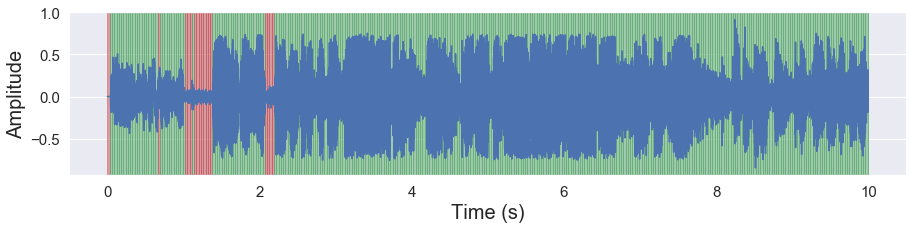

In [49]:
malaya_speech.extra.visualization.visualize_vad(y, frames_webrtc, sr)

In [50]:
%%time

frames = list(malaya_speech.utils.generator.frames(y, 50, sr))
result = p.emit(frames)
frames_deep_batch = [(frame, result['flatten'][no]) for no, frame in enumerate(frames)]

CPU times: user 224 ms, sys: 23.1 ms, total: 247 ms
Wall time: 120 ms


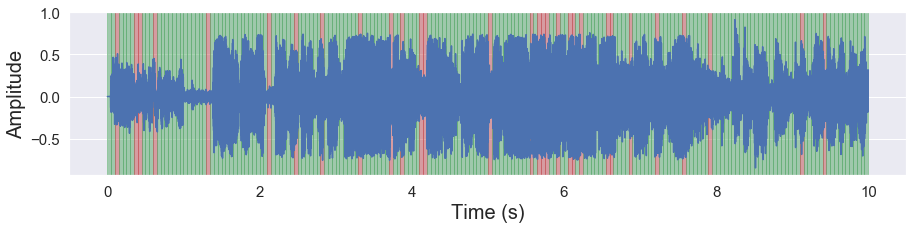

In [51]:
malaya_speech.extra.visualization.visualize_vad(y, frames_deep_batch, sr)

### Groupby based on time threshold

Group multiple frames based on label and threshold to stop.

```python
def group_frames_threshold(frames, threshold_to_stop: float = 0.3):
    """
    Group multiple frames based on label and threshold to stop.

    Parameters
    ----------
    frames: List[Tuple[Frame, label]]
    threshold_to_stop: float, optional (default = 0.3)
        If `threshold_to_stop` is 0.3, means that, length same label samples must at least 0.3 second.

    Returns
    -------
    result : List[Tuple[Frame, label]]
    """
```

In [52]:
%%time

result = p.emit(frames)
frames_deep_batch = [(frame, result['flatten'][no]) for no, frame in enumerate(frames)]

CPU times: user 200 ms, sys: 21.7 ms, total: 222 ms
Wall time: 110 ms


In [53]:
grouped_deep = malaya_speech.utils.group.group_frames(frames_deep_batch)
grouped_deep_threshold = malaya_speech.utils.group.group_frames_threshold(grouped_deep, 0.05)

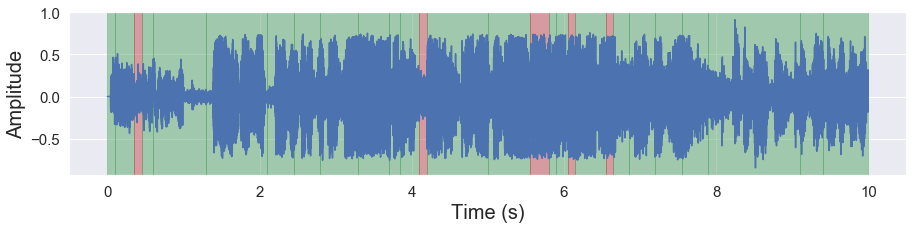

In [54]:
malaya_speech.extra.visualization.visualize_vad(y, grouped_deep_threshold, sr)

In [55]:
%%time

frames_deep_factor3 = [(frame, model_factor3(frame)) for frame in frames]

CPU times: user 514 ms, sys: 36.5 ms, total: 551 ms
Wall time: 459 ms


In [56]:
grouped_deep = malaya_speech.utils.group.group_frames(frames_deep_batch)
grouped_deep_threshold = malaya_speech.utils.group.group_frames_threshold(grouped_deep, 0.05)

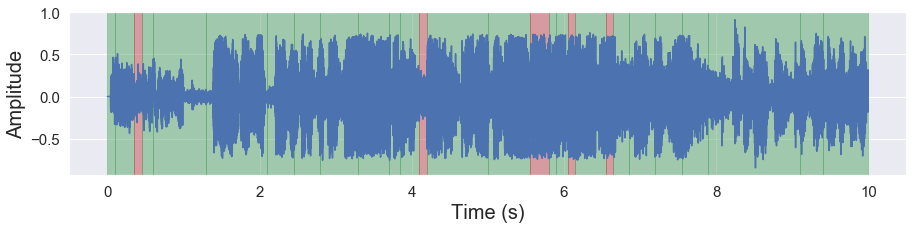

In [57]:
malaya_speech.extra.visualization.visualize_vad(y, grouped_deep_threshold, sr)

### Load Quantized deep model

To load 8-bit quantized model, simply pass `quantized = True`, default is `False`.

We can expect slightly accuracy drop from quantized model, and not necessary faster than normal 32-bit float model, totally depends on machine.

In [58]:
quantized_model = malaya_speech.vad.deep_model(model = 'marblenet-factor1', quantized = True)

1.00MB [00:00, 1.47MB/s]                   


In [60]:
%%time

frames_deep_factor1 = [(frame, model_factor1(frame)) for frame in frames]

CPU times: user 358 ms, sys: 26.2 ms, total: 384 ms
Wall time: 299 ms


In [61]:
%%time

frames_deep_factor1_quantized = [(frame, quantized_model(frame)) for frame in frames]

CPU times: user 374 ms, sys: 28.3 ms, total: 403 ms
Wall time: 298 ms


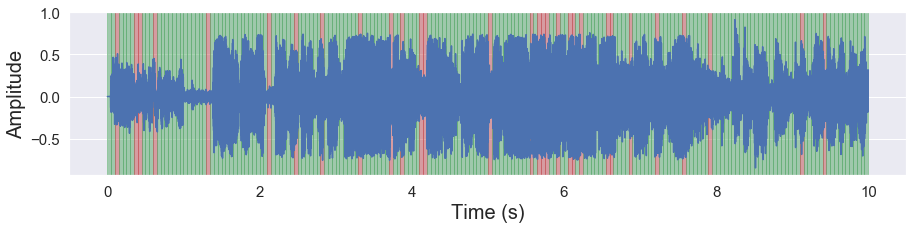

In [62]:
malaya_speech.extra.visualization.visualize_vad(y, frames_deep_factor1, sr)

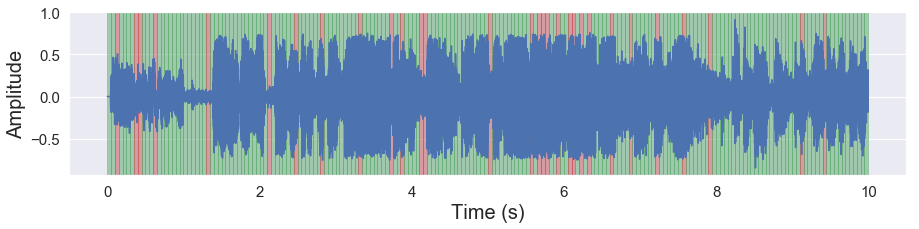

In [63]:
malaya_speech.extra.visualization.visualize_vad(y, frames_deep_factor1_quantized, sr)